In [234]:
from IPython.display import Image
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from scipy.spatial.distance import cdist, pdist
import collections
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
import pandas as pd
import numpy as np
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Q1 (15 points) 

#### This question is to be solved by hand.

Given the following learned Bayesian network structure explaining the relationships between variables in container shipping data:

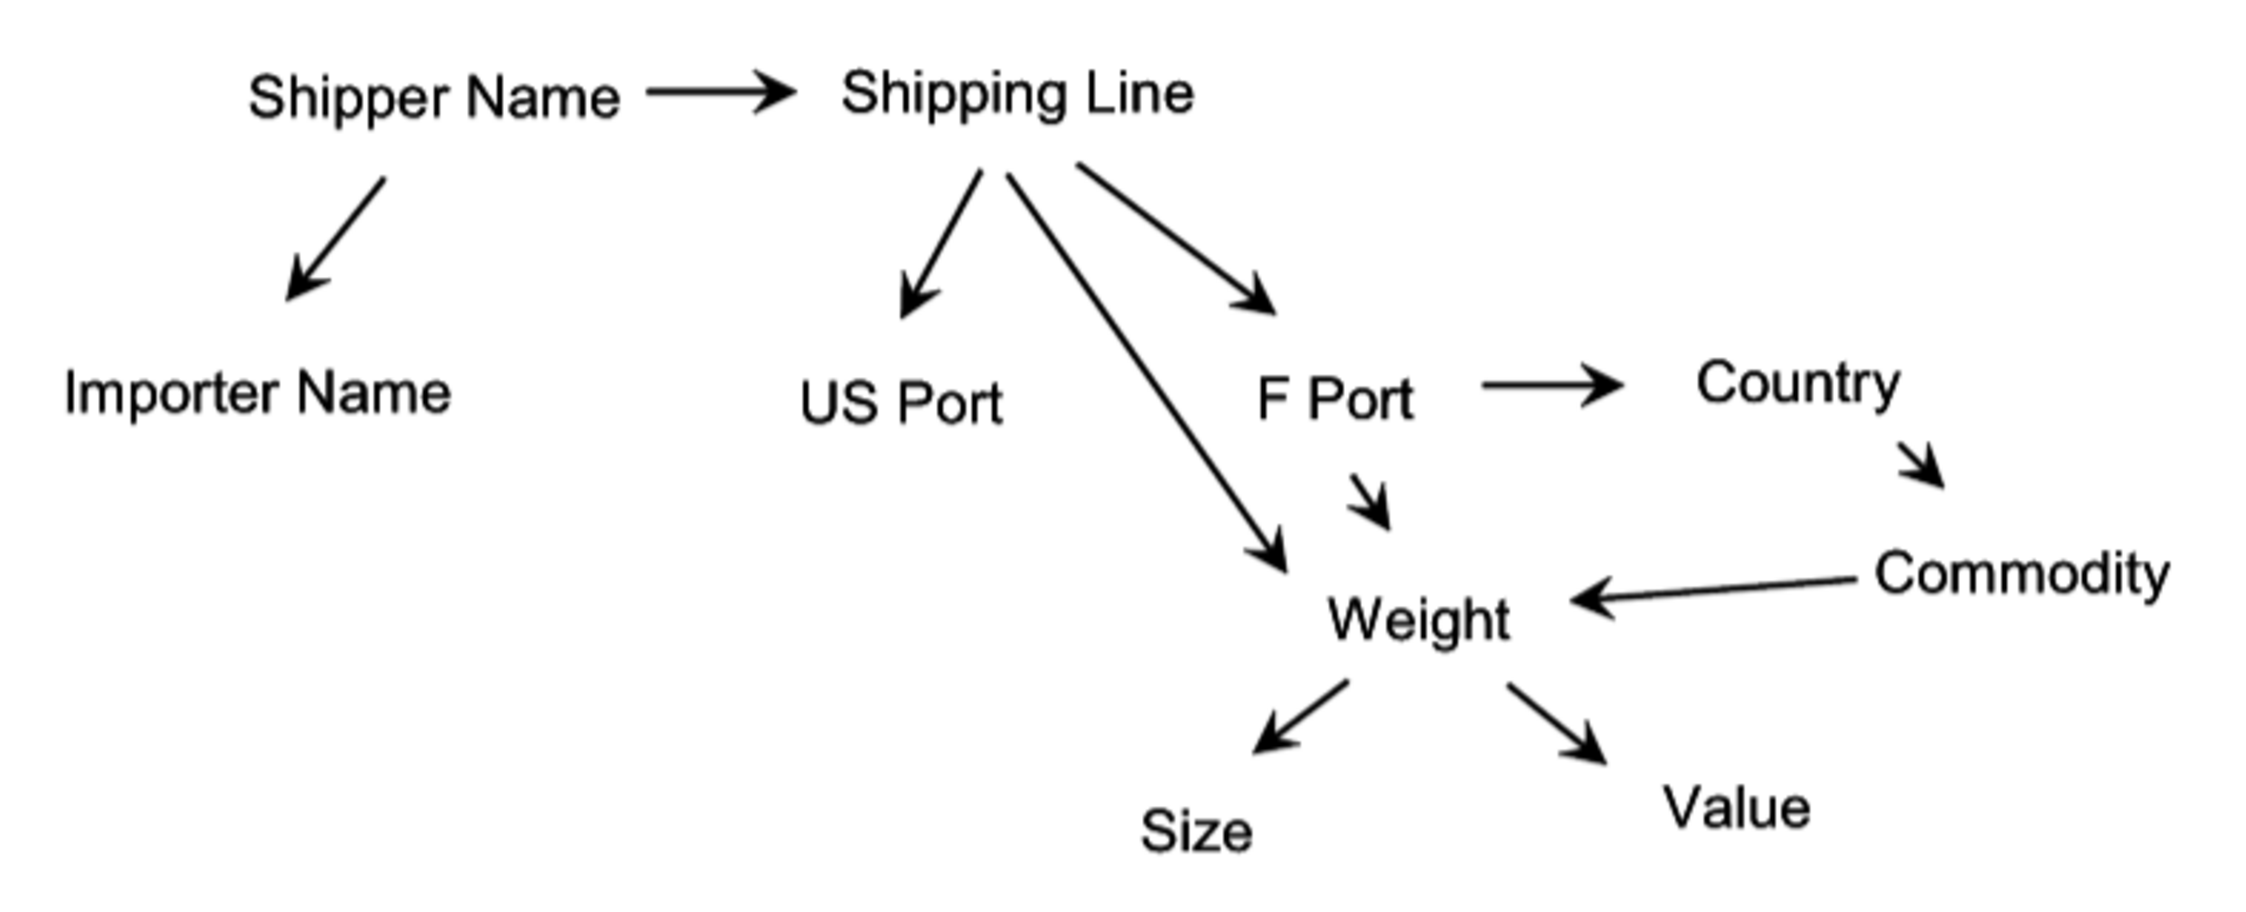

In [4]:
Image('HW3Q1.png')

1) Which of the following conditional independence relationships hold? Choose “Independent” or “Dependent” for each (6 points):

CI (Shipper Name, Value | F Port)?

$Dependent$

CI (Shipper Name, Value | Shipping Line)? 

$Independent$

CI (Foreign Port, Commodity | Country)? 

$Independent$

CI (Foreign Port, Commodity | County, Weight)? 

$Independent$

2) Now consider a smaller dataset with only four discrete attributes (Shipping Line, US Port, Foreign Port, Weight), and the following conditional probability distributions:

Shipping Line: CSCO (70%), ASCO (30%)

Foreign Port | Shipping Line = CSCO: Yokohama (40%), Vancouver (60%)

Foreign Port | Shipping Line = ASCO: Vancouver (100%)

US Port | Shipping Line = ASCO: Seattle (100%)

US Port | Shipping Line = CSCO: Seattle (80%), Los Angeles (20%)

Weight | Shipping Line = ASCO, Foreign Port = Vancouver: Light (30%), Medium (50%), Heavy (20%)

Weight | Shipping Line = CSCO, Foreign Port = Vancouver: Light (15%), Medium (70%), Heavy (15%)

Weight | Shipping Line = CSCO, Foreign Port = Yokohama: Light (10%), Medium (30%), Heavy (60%)

Which of the following packages is most anomalous?

a) A heavy package shipped from Vancouver to Seattle by ASCO

 $P(Heavy, Vancouver, Seattle|ASCO) = 0.2 * 1.0 * 1.0 * 0.3 = 0.06$

b) A heavy package shipped from Vancouver to Seattle by CSCO

$P(Heavy, Vancouver, Seattle|CSCO) = 0.15 * 0.60 * 0.80 * 0.7 = 0.0504$

c) A heavy package shipped from Yokohama to Los Angeles by CSCO

$P(Heavy, Yokohama, Los Angeles|CSCO) = 0.6 * 0.4 * 0.2 * 0.7 = 0.0336 $

To answer this question, compute the likelihood of each package given the Bayesian Network (lowest likelihood = most anomalous). You must show your calculations to receive credit. (9 points)

(Your answers here, including all calculations)

##### From the calculations above, the most anamalous package is package (c) with lowest likelihood of 0.0336. 

### Q2. Bayesian Network Learning (35 points)

In this question, we use dataset: "HW3Q2.csv" for Bayesian Network Learning.

In [2]:
from sklearn.model_selection import train_test_split
data2=pd.read_csv("HW3Q2.csv")
train,test=train_test_split(data2,random_state=9,test_size=0.4)
data2.head()

A  B  C  D  E  F
0  1  0  0  0  1  1
1  2  0  0  1  0  1
2  3  1  0  1  1  1
3  2  0  0  1  1  1
4  1  0  1  0  1  1

a) Use the training data to select the best structure you want to use for Bayesian Network Learning. Please use Hill Climbing with BIC score metric. (10 points)

b) Use the Bayesian Estimator to estimate the CPDs for your model and visualize the network with CPDs. (15 points)

c) Use the model to predict "A" for the testing dataset. Report the out-of-sample prediction accuracy. (10 points)   

#### a)

In [3]:
# your answers here
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BdeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel


In [15]:
hc = HillClimbSearch(data2, scoring_method=BicScore(data2))
best_model = hc.estimate()
print(best_model.edges())

[('B', 'A'), ('D', 'A'), ('F', 'A')]


##### b)

In [16]:
from pgmpy.estimators import BayesianEstimator

best_model.fit(train, estimator=BayesianEstimator, prior_type='K2')
for cpd in best_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
print (best_model.local_independencies(best_model.nodes()))

CPD of A:
+------+-----------------------+----------------------+---------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+
| B    | B(0)                  | B(0)                 | B(0)                | B(0)                 | B(1)                 | B(1)                 | B(1)                 | B(1)                  |
+------+-----------------------+----------------------+---------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+
| D    | D(0)                  | D(0)                 | D(1)                | D(1)                 | D(0)                 | D(0)                 | D(1)                 | D(1)                  |
+------+-----------------------+----------------------+---------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+
| F    | F(0)       

##### c)

In [54]:
predicted_test = best_model.predict(test.loc[:,"B":"F"])
print ("Out of sample:",(test.loc[:,'A']==predicted_test['A']).mean())

Out of sample: 0.5065


### Q3. Clustering: Spatial and Temporal Distributions of Chicago Crimes (50 points)

In this question you will use k-means and Gaussian mixture clustering in sklearn and hierarchical clustering in scipy to answer the question, “Do different types of crime display different trends over space and time?”  The dataset “HW3Q3_1.csv” consists of data for 119 different types of crime, each of which occurred at least 100 times in Chicago during the year 2016.  For each crime type, we have various features representing the spatial and temporal distribution of crime, including:

- The proportion of all crimes of that type that occurred on each day of the week (day_Sun, day_Mon, …, day_Sat).

- The proportion of all crimes of that type that occurred on each hour of the day (hour_0 = midnight to 12:59am, hour_1 = 1am to 1:59am, …, hour_23 = 11pm to 11:59pm).

- The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago (community_area_1 … community_area_77).

We also have, for each crime type, its categorization by the FBI:

- Category = “P1V” corresponds to Part 1 Violent Crime, i.e., serious violent crimes

- Category = “P1P” corresponds to Part 1 Property Crime, i.e., serious property crimes

- Category = “P2” corresponds to Part 2 (less serious) crimes.

To answer parts a through f, you should cluster the 119 crime types using k-means into k = 3 clusters using only the hour of day (hour_0..hour_23) attributes.

a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

c) Do you notice any consistent trends about which crime types are assigned to which cluster?  Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)  

d) Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (5 pts)

e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)

f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)


In [18]:
data3=pd.read_csv("HW3Q3_1.csv")
data3.head()

crime_type Category   day_Sun   day_Mon  \
0                          ARSON: BY FIRE      P1P  0.138810  0.135977   
1     ASSAULT: AGG PO HANDS NO/MIN INJURY       P2  0.151852  0.118519   
2            ASSAULT: AGGRAVATED: HANDGUN      P1V  0.149912  0.139405   
3  ASSAULT: AGGRAVATED: OTHER DANG WEAPON      P1V  0.125000  0.139000   
4      ASSAULT: AGGRAVATED: OTHER FIREARM      P1V  0.156863  0.107843   

    day_Tue   day_Wed   day_Thu   day_Fri   day_Sat    hour_0  \
0  0.155807  0.121813  0.130312  0.147309  0.169972  0.073654   
1  0.162963  0.122222  0.129630  0.129630  0.185185  0.055556   
2  0.141506  0.131349  0.136953  0.133100  0.167776  0.040630   
3  0.148000  0.153000  0.133000  0.142000  0.160000  0.034000   
4  0.166667  0.117647  0.147059  0.117647  0.186275  0.009804   

         ...          community_area_68  community_area_69  community_area_70  \
0        ...                   0.019830           0.016997           0.019830   
1        ...                   0.037037           0.048148           0.018519   
2        ...                   0.035377           0.031524           0.013310   
3        ...                   0.028000           0.030000           0.014000   
4        ...                   0.029412           0.019608           0.009804   

   community_area_71  community_area_72  community_area_73  community_area_74  \
0           0.022663           0.005666           0.000000           0.002833   
1           0.025926           0.003704           0.003704           0.003704   
2           0.042732           0.002102           0.017863           0.000000   
3           0.037000           0.003000           0.010000           0.002000   
4           0.019608           0.000000           0.000000           0.000000   

   community_area_75  community_area_76  community_area_77  
0           0.005666           0.000000           0.002833  
1           0.011111           0.011111           0.007407  
2           0.012259           0.002102           0.003152  
3           0.002000           0.003000           0.006000  
4           0.009804           0.000000           0.000000  

[5 rows x 110 columns]

In [19]:
data4=pd.read_csv("HW3Q3_2.csv")
data4.head()

Community Area Number COMMUNITY AREA NAME   centroid_x   centroid_y  \
0                      1         Rogers Park  1164399.219  1947666.815   
1                      2          West Ridge  1158307.200  1943243.722   
2                      3              Uptown  1168228.082  1930980.022   
3                      4      Lincoln Square  1159618.804  1933105.743   
4                      5        North Center  1161104.228  1924056.010   

   PERCENT OF HOUSING CROWDED  PERCENT HOUSEHOLDS BELOW POVERTY  \
0                         7.7                              23.6   
1                         7.8                              17.2   
2                         3.8                              24.0   
3                         3.4                              10.9   
4                         0.3                               7.5   

   PERCENT AGED 16+ UNEMPLOYED  PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA  \
0                          8.7                                          18.2   
1                          8.8                                          20.8   
2                          8.9                                          11.8   
3                          8.2                                          13.4   
4                          5.2                                           4.5   

   PERCENT AGED UNDER 18 OR OVER 64  PER CAPITA INCOME   \
0                              27.5               23939   
1                              38.5               23040   
2                              22.2               35787   
3                              25.5               37524   
4                              26.2               57123   

   PERCENT OF HOUSING UNITS VACANT  NUM_CRIMES_2016  
0                        11.870556             3420  
1                         9.870385             3068  
2                         8.672137             3330  
3                         8.600422             1859  
4                        10.100636             1280

#### a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster. (5 pts)

In [271]:
df = pd.DataFrame(data3.loc[:,'hour_0':'hour_23'])
df.index = data3.crime_type

n=3
import sklearn.cluster as cluster
KM=cluster.KMeans(n_clusters=n, random_state=321)
res=KM.fit(df)

print(res.labels_)
print(res.cluster_centers_)

[1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 0 2 2 2 2 2 2 1 1 0 1 0 1 1 1 1 1 2 0 0 0 0 1 0 0 1 0 0 0 0 0 0 2 1 1
 2 2 1 0 0 2 2 0 2 2 1 1 0 2 2 2 1 1 0 2 0 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2
 1 1 1 2 1 0 1 1]
[[ 0.02619541  0.01534886  0.01175124  0.00587152  0.00263964  0.0014209
   0.00386482  0.00720534  0.01114631  0.02133468  0.05256103  0.07840946
   0.06079347  0.05742985  0.0586302   0.04429557  0.03858645  0.04189836
   0.07130495  0.10857434  0.09160648  0.08169684  0.06698966  0.04044462]
 [ 0.05364158  0.04182416  0.03691183  0.03104211  0.02510576  0.01886402
   0.01946212  0.02434162  0.02766839  0.0335171   0.03680552  0.03720506
   0.04254665  0.03994431  0.04208987  0.0473956   0.05170137  0.05425891
   0.05757893  0.05599685  0.0575726   0.05411778  0.05837336  0.0520345 ]
 [ 0.04157028  0.01223869  0.01025269  0.00924632  0.00921948  0.00754317
   0.01317345  0.02430216  0.05037357  0.09206671  0.07950032  0.06126421
   0.08600108  0

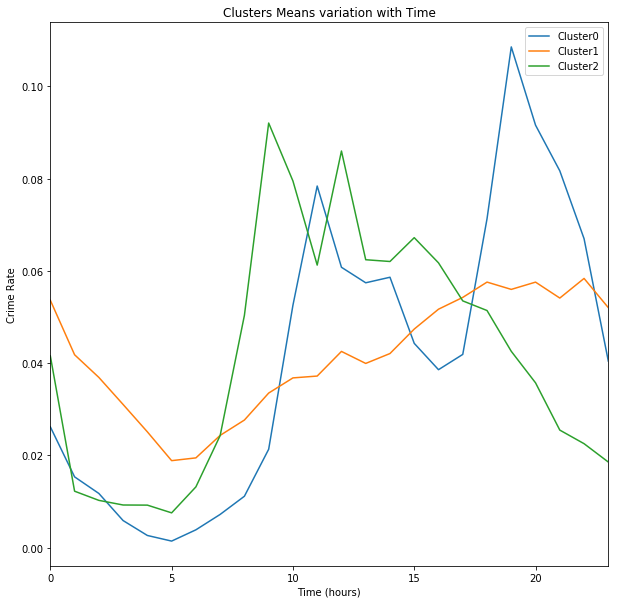

In [272]:
pd.DataFrame(res.cluster_centers_.T, columns = ['Cluster0', 'Cluster1', 'Cluster2']).plot(figsize = (10,10), legend=True)
pl.xlabel('Time (hours)')
pl.ylabel('Crime Rate')
pl.title('Clusters Means variation with Time');

#### b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

All three clusters show different patterns throughout the day. For cluster 0 we see that there are 2 peaks at around 10 AM and 7 PM. One can imagine such peaks as the two time are peak rush hours and hence more probability of crime.

For cluster 1, the plot is graually increasing throughout the day and peaks at around 10PM. The crime associated with this clusters could be something like auto theft or vandalism which peaks at night.

For clsuter 2 we see 2 peaks and both around noon. These crime associated with this cluster would also be something that would happen in non-peak hours.

#### c) Do you notice any consistent trends about which crime types are assigned to which cluster? Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)

In [92]:
data3['cluster_labels'] = res.labels_

In [103]:
print('Crimes in CLuster 0: {}'.format(data3.crime_type[data3.cluster_labels==0]))
print("\n")
print('Crimes in CLuster 1: {}'.format(data3.crime_type[data3.cluster_labels==1]))
print("\n")
print('Crimes in CLuster 2: {}'.format(data3.crime_type[data3.cluster_labels==2]))

Crimes in CLuster 0: 6                   ASSAULT: PRO EMP HANDS NO/MIN INJURY
19                  BATTERY: PRO EMP HANDS NO/MIN INJURY
24                              BURGLARY: UNLAWFUL ENTRY
36     DECEPTIVE PRACTICE: ATTEMPT - FINANCIAL IDENTI...
37                       DECEPTIVE PRACTICE: BOGUS CHECK
38                 DECEPTIVE PRACTICE: COUNTERFEIT CHECK
40                 DECEPTIVE PRACTICE: CREDIT CARD FRAUD
41     DECEPTIVE PRACTICE: FINANCIAL IDENTITY THEFT $...
42     DECEPTIVE PRACTICE: FINANCIAL IDENTITY THEFT O...
43                           DECEPTIVE PRACTICE: FORGERY
44          DECEPTIVE PRACTICE: FRAUD OR CONFIDENCE GAME
45             DECEPTIVE PRACTICE: ILLEGAL USE CASH CARD
56                    NARCOTICS: FOUND SUSPECT NARCOTICS
71           OFFENSE INVOLVING CHILDREN: CHILD ABDUCTION
74             OFFENSE INVOLVING CHILDREN: OTHER OFFENSE
75                   OTHER OFFENSE: ANIMAL ABUSE/NEGLECT
79         OTHER OFFENSE: HARASSMENT BY ELECTRONIC MEANS
80        

##### *From the list above, we can infer that crimes infact show trend in the clusters. The first cluster group crimes that are related to general offence such as credit card theft or identity theft. CLuster 1 groups criminal offences such as assault, robbery, sex offence ertc whereas CLuster 3 groups crimes related to Narcotics and gun offence.*

#### d) Do the three clusters have different day-of-week trends? Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences. (5 pts)

In [276]:
df_day = pd.DataFrame(data3.loc[:,'day_Sun':'day_Sat'])
df_day.index = data3.crime_type

n=3
import sklearn.cluster as cluster
KM=cluster.KMeans(n_clusters=n, random_state = 321)
res=KM.fit(df_day)

print(res.labels_)
print(res.cluster_centers_)

[1 1 1 0 1 0 2 0 1 0 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 1 0 0 1 2 1 0 0 0 0 2
 2 2 1 0 2 2 2 2 1 1 0 0 1 0 1 1 1 0 1 0 0 2 0 0 0 0 0 1 0 0 1 2 0 0 1 0 0
 1 0 0 0 2 0 0 2 0 1 1 0 0 1 2 0 0 0 2 2 0 0 1 0 0 1 0 0 0 1 2 0 0 1 0 0 0
 0 1 0 0 1 0 1 0]
[[ 0.12800203  0.15166019  0.14852973  0.14268936  0.14583146  0.14978603
   0.13350119]
 [ 0.1656584   0.12967072  0.12825291  0.12579437  0.12736265  0.14965084
   0.17361009]
 [ 0.07215597  0.14228653  0.175196    0.17506321  0.16474889  0.17215722
   0.09839219]]


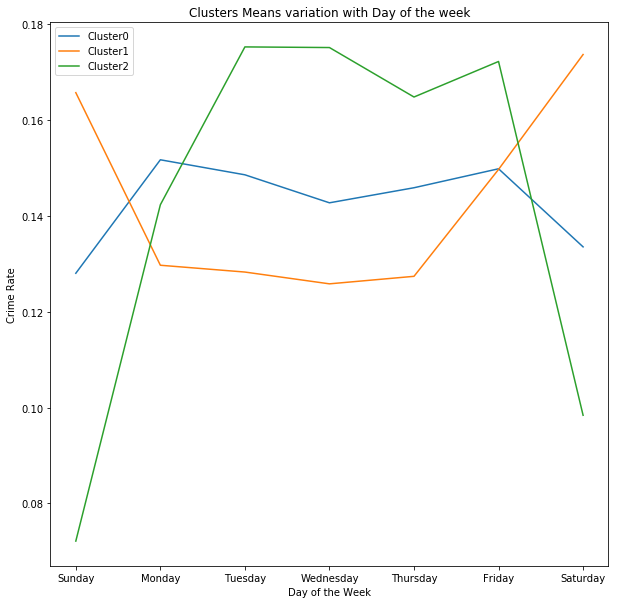

In [311]:
ax= pl.figure(figsize= (10,10)).add_subplot(111)
dummy = pd.DataFrame(res.cluster_centers_.T, columns = ['Cluster0', 'Cluster1', 'Cluster2'])
plot(dummy)
pl.xlabel('Day of the Week')
pl.ylabel('Crime Rate')
pl.legend(['Cluster0', 'Cluster1', 'Cluster2'], loc='best')
a = ax.get_xticks().tolist()
lis = ['Sunday','Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

for i in range(len(a)-2):
    a[i+1] = lis[i]
ax.set_xticklabels(a)

plt.title('Clusters Means variation with Day of the week');

#### e) Do the three clusters affect different types of communities/neighborhoods? To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster. You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.). You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)

In [125]:
df_com = pd.DataFrame(data3.loc[:,'community_area_1':'community_area_77'])

In [126]:
df_com.index = data3.cluster_labels

In [129]:
df_com.groupby(df_com.index).mean()

community_area_1  community_area_2  community_area_3  \
cluster_labels                                                         
0                       0.014446          0.014380          0.016437   
1                       0.014190          0.012614          0.013718   
2                       0.007818          0.005919          0.007367   

                community_area_4  community_area_5  community_area_6  \
cluster_labels                                                         
0                       0.010941          0.007502          0.024766   
1                       0.007307          0.004148          0.021163   
2                       0.002166          0.001113          0.006101   

                community_area_7  community_area_8  community_area_9  \
cluster_labels                                                         
0                       0.018054          0.053912          0.002169   
1                       0.010299          0.027837          0.000690   
2                       0.001626          0.013915          0.000376   

                community_area_10        ...          community_area_68  \
cluster_labels                           ...                              
0                        0.007858        ...                   0.017873   
1                        0.003514        ...                   0.026130   
2                        0.001264        ...                   0.038343   

                community_area_69  community_area_70  community_area_71  \
cluster_labels                                                            
0                        0.020703           0.010150           0.023909   
1                        0.028922           0.009371           0.028839   
2                        0.027435           0.002366           0.033006   

                community_area_72  community_area_73  community_area_74  \
cluster_labels                                                            
0                        0.005234           0.011028           0.004348   
1                        0.002854           0.011386           0.001584   
2                        0.000951           0.010082           0.000555   

                community_area_75  community_area_76  community_area_77  
cluster_labels                                                           
0                        0.009446           0.009696           0.012677  
1                        0.007115           0.010147           0.007367  
2                        0.007153           0.000911           0.001522  

[3 rows x 77 columns]

In [179]:
print('Communities with disproportionate number of crime for cluster 0 are: \n{}'.format(df_com.iloc[0][df_com.iloc[0]> (df_com.iloc[0].mean() + (3*df_com.iloc[0].std()))]))
print('\n\n')
print('Communities with disproportionate number of crime for cluster 1 are: \n{}'.format(df_com.iloc[1][df_com.iloc[1]> (df_com.iloc[1].mean() + (3*df_com.iloc[1].std()))]))
print('\n\n')
print('Communities with disproportionate number of crime for cluster 2 are: \n{}'.format(df_com.iloc[2][df_com.iloc[2]> (df_com.iloc[2].mean() + (3*df_com.iloc[2].std()))]))

Communities with disproportionate number of crime for cluster 0 are: 
community_area_25    0.079320
community_area_66    0.062323
Name: 1, dtype: float64



Communities with disproportionate number of crime for cluster 1 are: 
community_area_25    0.070370
community_area_43    0.059259
Name: 1, dtype: float64



Communities with disproportionate number of crime for cluster 2 are: 
community_area_25    0.073555
Name: 1, dtype: float64


From the results above, the community area 25 is a definite outlier 

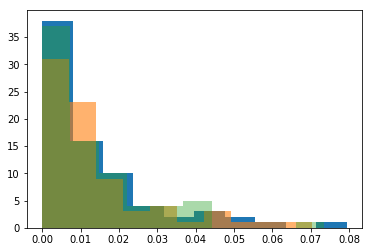

In [282]:
pl.hist(df_com.iloc[0]), pl.hist(df_com.iloc[1], alpha=0.6), pl.hist(df_com.iloc[2], alpha = 0.4)
pl.title='Distribution of three clusters'

Rough Distribution of three clusters (for rough analysis purpose)

In [188]:
data4[data4['Community Area Number'].astype(int) == 25].ix[:,4:]

PERCENT OF HOUSING CROWDED  PERCENT HOUSEHOLDS BELOW POVERTY  \
24                         6.3                              28.6   

    PERCENT AGED 16+ UNEMPLOYED  PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA  \
24                         22.6                                          24.4   

    PERCENT AGED UNDER 18 OR OVER 64  PER CAPITA INCOME   \
24                              37.9               15957   

    PERCENT OF HOUSING UNITS VACANT  NUM_CRIMES_2016  
24                        14.188517            15719

In [182]:
data4.ix[:,4:].describe()

PERCENT OF HOUSING CROWDED  PERCENT HOUSEHOLDS BELOW POVERTY  \
count                   77.000000                         77.000000   
mean                     4.923377                         21.766234   
std                      3.682887                         11.529957   
min                      0.300000                          3.300000   
25%                      2.300000                         13.200000   
50%                      3.800000                         18.900000   
75%                      6.800000                         29.200000   
max                     15.800000                         56.500000   

       PERCENT AGED 16+ UNEMPLOYED  \
count                    77.000000   
mean                     15.372727   
std                       7.543412   
min                       4.700000   
25%                       9.200000   
50%                      13.900000   
75%                      20.000000   
max                      35.900000   

       PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA  \
count                                     77.000000   
mean                                      20.341558   
std                                       11.823152   
min                                        2.500000   
25%                                       11.800000   
50%                                       18.500000   
75%                                       26.600000   
max                                       54.800000   

       PERCENT AGED UNDER 18 OR OVER 64  PER CAPITA INCOME   \
count                         77.000000           77.000000   
mean                          35.746753        25563.168831   
std                            7.327716        15293.098259   
min                           13.500000         8201.000000   
25%                           32.000000        15754.000000   
50%                           38.100000        21323.000000   
75%                           40.500000        28887.000000   
max                           51.500000        88669.000000   

       PERCENT OF HOUSING UNITS VACANT  NUM_CRIMES_2016  
count                        77.000000        77.000000  
mean                         12.442935      3262.246753  
std                           5.837773      2790.716590  
min                           4.427736       283.000000  
25%                           8.600422      1229.000000  
50%                          10.255709      2296.000000  
75%                          15.839488      4604.000000  
max                          29.411765     15719.000000

*Comparing the statistics for community area 25, we can say that this area is a good candidate for criminal activities as the % household below poverty line is 28.6 while the mean of the city is 21.7%, unemployment % in CA 25 is 22.6% while city mean is 15.3%. Additionally, this area has the highest number of crimes in 2016.*

#### f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

In [190]:
fbi_comp = data3[['Category', 'cluster_labels']]
fbi_comp.head()

Category  cluster_labels
0      P1P               1
1       P2               1
2      P1V               1
3      P1V               1
4      P1V               1

In [198]:
fbi_comp.groupby([fbi_comp['Category'], fbi_comp.cluster_labels]).size()

Category  cluster_labels
P1P       0                  4
          1                 11
P1V       1                 24
P2        0                 23
          1                 34
          2                 23
dtype: int64

In [202]:
fbi_comp.groupby([fbi_comp.cluster_labels, fbi_comp['Category']]).size()

cluster_labels  Category
0               P1P          4
                P2          23
1               P1P         11
                P1V         24
                P2          34
2               P2          23
dtype: int64

*The FBI categories don't really mix well with our clusters. For instance cluster 2 comprises of inly 1 category of crimes while the other clusters have some proportions of other crime types as welll.*

### g) For part g, you will use the same dataset to compare the clusters produced by several different methods. But this time you should cluster using only the day-of-week (not hour-of-day) attributes (day_Sun..day_Sat). Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric. In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify). For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)

#### i) K-Means

In [217]:
df_day = pd.DataFrame(data3.loc[:,'day_Sun':'day_Sat'])
df_day.index = data3.crime_type

In [218]:
range_n_clusters = range(2,12)

for n_clusters in range_n_clusters:
    cluster_labels= KMeans(n_clusters, random_state=1).fit(df_day).labels_
    silhouette_avg = silhouette_score(df_day, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.2365303906851532
For n_clusters = 3, the average silhouette_score is : 0.22561572529385884
For n_clusters = 4, the average silhouette_score is : 0.2238928077465591
For n_clusters = 5, the average silhouette_score is : 0.23983354287066633
For n_clusters = 6, the average silhouette_score is : 0.16023468146585954
For n_clusters = 7, the average silhouette_score is : 0.18302593684060092
For n_clusters = 8, the average silhouette_score is : 0.16128901421505434
For n_clusters = 9, the average silhouette_score is : 0.18082859101435006
For n_clusters = 10, the average silhouette_score is : 0.1671311637459432
For n_clusters = 11, the average silhouette_score is : 0.16786821570453872


From the results above, 5 clusters would give us the least SSE.

In [224]:
km = KMeans(random_state=100,n_clusters=5)
res=km.fit(df_day)
print ('Cluster assignments:',res.labels_)
print ('Number of elements in each cluster:\n',collections.Counter(res.labels_))

Cluster assignments: [2 2 2 0 2 2 3 0 2 0 2 2 2 2 2 2 2 2 2 3 2 0 0 0 0 0 2 0 0 2 3 2 0 0 0 2 3
 3 3 2 0 3 3 3 3 2 2 0 0 2 2 2 4 2 2 2 0 0 3 0 0 1 0 0 2 0 0 2 0 0 0 2 0 0
 4 1 0 0 3 0 0 1 0 2 2 0 0 2 3 0 0 0 1 3 0 0 2 0 0 2 0 0 2 2 1 0 0 2 0 0 0
 0 2 0 0 2 2 2 0]
Number of elements in each cluster:
 Counter({0: 54, 2: 44, 3: 14, 1: 5, 4: 2})


#### ii) Gaussian Mixture Model

In [229]:
range_n_clusters = range(2,12)

for n_clusters in range_n_clusters:
    res= GaussianMixture(n_clusters,random_state=111).fit(df_day)
    silhouette_avg = silhouette_score(df_day, res.predict(df_day))
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.2946566408627777
For n_clusters = 3, the average silhouette_score is : 0.1181517590240826
For n_clusters = 4, the average silhouette_score is : 0.25982110318075763
For n_clusters = 5, the average silhouette_score is : 0.15246493672001096
For n_clusters = 6, the average silhouette_score is : 0.15778079629247485
For n_clusters = 7, the average silhouette_score is : 0.15503132134082528
For n_clusters = 8, the average silhouette_score is : 0.12317489305503665
For n_clusters = 9, the average silhouette_score is : 0.10625614100445449
For n_clusters = 10, the average silhouette_score is : 0.1034717759519415
For n_clusters = 11, the average silhouette_score is : 0.11393084347481054


In [319]:
gmm = GaussianMixture(n_components=2,random_state=111)
res_gm = gmm.fit(df_day)
#print ('Number of elements in cluster 1:\n',len(res_gm.predict(df_day)[res_gm.predict(df_day) == 1]))
#print ('Number of elements in cluster 2:\n',len(res_gm.predict(df_day)[res_gm.predict(df_day) == 0]))
print ('\nCluster centers:\n',res_gm.means_)
#print ('\nCluster covariances:\n',res.covariances_)
print ('\nLog-likelihood per sample:',res_gm.score(df_day))

print(' \nNumber of elements in cluster:\n {}'.format(collections.Counter(res_gm.predict(df_day))))



Cluster centers:
 [[ 0.14288535  0.14278003  0.14013814  0.13785527  0.13840267  0.14874065
   0.14919789]
 [ 0.0960813   0.14309085  0.16473689  0.15562431  0.15630445  0.16796486
   0.11619734]]

Log-likelihood per sample: 19.6118406693
 
Number of elements in cluster:
 Counter({0: 93, 1: 26})


#### iii) Single Link

In [236]:
range_n_clusters = range(2,12)
Z_single = linkage(df_day, 'single')

for n_clusters in range_n_clusters:
    cluster_labels=fcluster(Z_single, n_clusters, criterion='maxclust')    
    silhouette_avg = silhouette_score(df_day, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.6377648080667613
For n_clusters = 3, the average silhouette_score is : 0.5568477382969328
For n_clusters = 4, the average silhouette_score is : 0.40557775075981567
For n_clusters = 5, the average silhouette_score is : 0.38770381887486705
For n_clusters = 6, the average silhouette_score is : 0.3900761951022192
For n_clusters = 7, the average silhouette_score is : 0.34621844820394393
For n_clusters = 8, the average silhouette_score is : 0.32899815764355916
For n_clusters = 9, the average silhouette_score is : 0.32542192748924165
For n_clusters = 10, the average silhouette_score is : 0.3132151039050357
For n_clusters = 11, the average silhouette_score is : 0.21831462782301697


*Silhouette score is highest for number of clusters=2*

In [241]:
cluster_sl = fcluster(Z_single, 2, criterion='maxclust')
print ('\nNumber of elements in each cluster:\n',collections.Counter(cluster_sl))


Number of elements in each cluster:
 Counter({1: 118, 2: 1})


#### iv) Complete Link

In [242]:
range_n_clusters = range(2,12)
Z_complete = linkage(df_day, 'complete')

for n_clusters in range_n_clusters:
    cluster_labels=fcluster(Z_complete, n_clusters, criterion='maxclust')    
    silhouette_avg = silhouette_score(df_day, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.6100646113547021
For n_clusters = 3, the average silhouette_score is : 0.1726871814656612
For n_clusters = 4, the average silhouette_score is : 0.19215169374768618
For n_clusters = 5, the average silhouette_score is : 0.1502520782249978
For n_clusters = 6, the average silhouette_score is : 0.15229681572228101
For n_clusters = 7, the average silhouette_score is : 0.1492626761610946
For n_clusters = 8, the average silhouette_score is : 0.10130440123428049
For n_clusters = 9, the average silhouette_score is : 0.1006650389916478
For n_clusters = 10, the average silhouette_score is : 0.11061132431547085
For n_clusters = 11, the average silhouette_score is : 0.12537141856431583


*Silhouette score is highest for number of clusters=2*

In [310]:
cluster_cl = fcluster(Z_complete, t=2, criterion='maxclust')
print ('\nNumber of elements in each cluster:\n',collections.Counter(cluster_cl))


Number of elements in each cluster:
 Counter({2: 117, 1: 2})
